### Common Visualization functions for all tasks

In [8]:
t1_path = "/h/sahiravi/VAR/t1_humaneval_v2.csv"
t2_path = "/h/sahiravi/VAR/t2_humaneval_v2.csv"
t3_path = "/h/sahiravi/VAR/t3_humaneval_v2.csv"

In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from IPython.display import display, Video, HTML
import seaborn as sns

# Function to find the distribution of the four metrics
def calculate_metric_distribution(df, task_prefix):
    metrics = ['vis', 'depth', 'grammar', 'correctness', 'detail']
    metric_counts = {metric: [] for metric in metrics}
    
    # Collect scores from the dataset
    for index, row in df.iterrows():
        submitted_data_dict = ast.literal_eval(row['Submitted Data'])
        task_data = submitted_data_dict.get("Data", {}).get("taskData", {})
        
        for metric in metrics:
            score = task_data.get(f"{task_prefix}_{metric}", None)
            if score is not None:
                metric_counts[metric].append(int(score))
    
    # Plot distribution for each metric with percentages on bars
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        metric_data = metric_counts[metric]
        
        if len(metric_data) > 0:
            ax = sns.histplot(metric_data, bins=5, ax=axes[i], kde=False, stat='percent', color='skyblue')
            axes[i].set_title(f'Distribution of {metric.capitalize()} Scores')
            axes[i].set_xlabel('Score')
            axes[i].set_ylabel('Percentage')

            # Add percentages on top of the bars
            total = len(metric_data)
            for p in ax.patches:
                percentage = f'{(p.get_height()):.1f}%'
                ax.annotate(percentage, 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='center', xytext=(0, 9), 
                            textcoords='offset points', fontsize=10, color='black')
        else:
            axes[i].set_title(f'No Data for {metric.capitalize()}')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display the average score for each metric
    for metric in metrics:
        if len(metric_counts[metric]) > 0:
            avg_score = sum(metric_counts[metric]) / len(metric_counts[metric])
            print(f"Average {metric.capitalize()} Score: {avg_score:.2f}")
        else:
            print(f"No data available for {metric.capitalize()}.")

# Function to parse "Task Data" and extract video links based on headers
def get_videos_and_reference(task_data, headers):
    task_data_dict = ast.literal_eval(task_data)
    row_data = task_data_dict.get("RowData", [])
    
    videos = {}
    reference_text = None
    
    # Extract the video URLs and reference text
    for item in row_data:
        column_header = item['ColumnHeader']
        if column_header in headers:
            videos[column_header] = item['CellData']
        if column_header == 'reference_text':
            reference_text = item['CellData']
    
    # Combine base URL and video names for each header
    base_url = next((item['CellData'] for item in row_data if item['ColumnHeader'] == 'videos_url'), None)
    for header in headers:
        if header in videos:
            videos[header] = f"{base_url}{videos[header]}"
        else:
            videos[header] = None
    
    return videos, reference_text

# Function to extract metrics based on the task configuration (t1, t2, t3)
def get_metrics(submitted_data, task_prefix):
    submitted_data_dict = ast.literal_eval(submitted_data)
    task_data = submitted_data_dict.get("Data", {}).get("taskData", {})
    
    metrics = ['correctness', 'depth','grammar', 'vis', 'detail']
    metrics_info = []
    
    # Gather each metric score and its corresponding reason
    for metric in metrics:
        score = task_data.get(f"{task_prefix}_{metric}", "N/A")
        reason = task_data.get(f"{metric}Reason", "N/A")
        metrics_info.append(f"{metric.capitalize()} Score: {score}")
        metrics_info.append(f"{metric.capitalize()} Reason: {reason}")
    
    return "\n".join(metrics_info)

# Function to display videos side by side
def display_videos(videos_dict):
    video_tags = []
    for header, video_link in videos_dict.items():
        if video_link:
            video_tags.append(f'<video src="{video_link}" controls width="300"></video>')
    
    return HTML(" ".join(video_tags))

# Configuration: choose 't1', 't2', or 't3'

def visualize(task_config, csv_file):
    df = pd.read_csv(csv_file)

    # Filter out rows where "Task Data" is None or NaN
    df_filtered = df[df['Task Data'].notna()]
    # Task header configuration
    task_headers_map = {
        't1': ['preevent'],
        't2': ['preevent', 'postevent'],
        't3': ['preevent', 'event', 'postevent']
    }

    # Display each video (or videos) based on configuration along with reference text and metrics
    for index, row in df_filtered.iterrows():
        headers = task_headers_map[task_config]
        videos, reference_text = get_videos_and_reference(row['Task Data'], headers)
        
        # Display the reference text
        print(f"Text Description {index}: {reference_text}")
        
        # Display the videos side by side
        display(display_videos(videos))
        
        # Get and print the corresponding metrics
        metrics_info = get_metrics(row['Submitted Data'], task_config)
        print("Metrics:\n", metrics_info)
        print("\n" + "="*50 + "\n")

    calculate_metric_distribution(df_filtered, task_config)

### Task 1 Plot

Text Description 0: The woman in the white shirt is seen swimming to the edge of the river after falling in the water.


Metrics:
 Correctness Score: 2
Correctness Reason: Part 2 is more likely to be the blonde haired woman in the white shirt falling from the swing into the water.
Depth Score: 2
Depth Reason: Prediction is probably wrong and the description does not capture the spirit of the action.
Grammar Score: 1
Grammar Reason: There are no grammar or spelling errors.
Vis Score: 1
Vis Reason: It seems to contradict what is about to happen.
Detail Score: 2
Detail Reason: There is very little detail.


Text Description 1: The woman cheers as she successfully reaches the other side by hanging onto the swinging rope.


Metrics:
 Correctness Score: 4
Correctness Reason: Mostly correct but lacks clear mention of balance or specific consequences.
Depth Score: 3
Depth Reason: Provides some thought but lacks depth or meaningful insight.
Grammar Score: 1
Grammar Reason: there are no grammatical errors 
Vis Score: 1
Vis Reason: the descriptive  follows what was happening in the video
Detail Score: 4
Detail Reason: has enough level of detail to differentiate between the woman and the tree


Text Description 3: Black and red players collide at midfield, once gets hurt


Metrics:
 Correctness Score: 2
Correctness Reason: they collide but not in the mid field area
Depth Score: 4
Depth Reason: they were in motion so they would obviously collide
Grammar Score: 1
Grammar Reason: it had correct grammar
Vis Score: 1
Vis Reason: they would obviously collide
Detail Score: 4
Detail Reason: more detailed


Text Description 6: Black player closest to ball falls on her face and gets embarrassed


Metrics:
 Correctness Score: 5
Correctness Reason: There is in fact a player in black near the ball, and she could fall on her face
Depth Score: 3
Depth Reason: Has detail, but doesn't say how the player falls 
Grammar Score: 1
Grammar Reason: Incomplete sentence, but instructions don't say that's bad, and everything else is grammatically correct 
Vis Score: 1
Vis Reason: Again, there is in fact a player in black near the ball, and she could fall 
Detail Score: 5
Detail Reason: Sufficient detail to identify who will fall


Text Description 10: Red Defender clears the ball away to safety


Metrics:
 Correctness Score: 1
Correctness Reason: It wasn't very descriptive. It was very simple. 
Depth Score: 1
Depth Reason: Wasnt that much depth.
Grammar Score: 1
Grammar Reason: It was ok written.
Vis Score: 1
Vis Reason: It follows the description.
Detail Score: 1
Detail Reason: Not alot of detail. 


Text Description 12: The woman has fallen into the water and her friend jumps in after her to save her.


Metrics:
 Correctness Score: 4
Correctness Reason: It makes the most sense and is clear. 
Depth Score: 4
Depth Reason: It was well written. 
Grammar Score: 1
Grammar Reason: It is well written with a few minor errors.
Vis Score: 1
Vis Reason: It makes the most logical sense. 
Detail Score: 4
Detail Reason: It had just the right amount of detail. 


Text Description 14: The man loses his balance and he and the woman both topple over and fall.


Metrics:
 Correctness Score: 5
Correctness Reason: This is the natural progression, that the man falls. 
Depth Score: 5
Depth Reason: IT is a very clear response
Grammar Score: 1
Grammar Reason: IT is reasonable
Vis Score: 1
Vis Reason: No contradiction
Detail Score: 4
Detail Reason: It is not super detailed, but the response does not require detail


Text Description 15: The woman tries to juggle and accidentally hits the man in the head with one of the items in her hands.


Metrics:
 Correctness Score: 5
Correctness Reason: Gives good description of the event
Depth Score: 4
Depth Reason: States she accidentally dropped item
Grammar Score: 1
Grammar Reason: Easy to read
Vis Score: 1
Vis Reason: It looked like the people were off balance to begin with so safe to assume an accident would occur
Detail Score: 5
Detail Reason: States the women on top dropped item


Text Description 17: The man who threw the pitch does a double take between the batter and the space behind him.  The batter looks on while this happens.


Metrics:
 Correctness Score: 5
Correctness Reason: The end of the video suggests that this is what will happen as the man who threw the pitch is looking behind him and the batter is looking that way as well.
Depth Score: 5
Depth Reason: Yes the video is highly suggestive that this is what will happen, for the reasons I described in my answer to the first question.
Grammar Score: 1
Grammar Reason: The grammar is perfect.
Vis Score: 1
Vis Reason: The description follows it perfectly. There is no contradiction based on what I can see in the end of the first video.
Detail Score: 5
Detail Reason: There is a high level of detail; its easy to tell what are the people and objects and what are their actions.


Text Description 18: The man who threw the pitch stands up and begins to express surprise.  The batter begins to make pleased gestures by swinging his bat around.


Metrics:
 Correctness Score: 2
Correctness Reason: It doesn't seem like either of the people are that excited about the hit off the bat. Usually there would be more of a reaction right after the hit.
Depth Score: 3
Depth Reason: There is some detail in the anticipated action in video 2. 
Grammar Score: 1
Grammar Reason: No grammatical errors.
Vis Score: 1
Vis Reason: It is not impossible for the description to have happened.
Detail Score: 4
Detail Reason: It is clear from the description who is being referenced.


Text Description 19: The skiier falls and begins to laugh as he lays in the snow.


Metrics:
 Correctness Score: 5
Correctness Reason: The text in green is exactly what I anticipated happening.
Depth Score: 3
Depth Reason: I thought the text could use some more imagination.
Grammar Score: 1
Grammar Reason: I didn't see any grammar mistakes in the example, although I thought the green text could be more descriptive.
Vis Score: 1
Vis Reason: I believe the description follows the video and accurately describes what is occurring or about to occur.
Detail Score: 2
Detail Reason: Similar to imagination, I felt there could be more detail in the description.


Text Description 20: The skiier successfully lands the jump and continues down the mountain.


Metrics:
 Correctness Score: 4
Correctness Reason: I would have added they land the jump on the edge and continue to grind down the mountain, but it is 80-90% of what I would have typed to describe it.
Depth Score: 5
Depth Reason: I think the video provides enough reasoning to justify typing this response. It is exactly what I would have personally done had I been writing it out. The depth is a tad lacking, but not enough to knock this down to a 4.
Grammar Score: 1
Grammar Reason: Perfect english, no errors.
Vis Score: 1
Vis Reason: It is exactly what I personally would have typed out, so I feel like it follows the video as well as you could hope for.
Detail Score: 2
Detail Reason: It has good detail to know the main character, but it omits a vital point that the jump is being done on a surface edge and the main character is "grinding" along said edge which is a vital piece of detail. The typing implies they are doing an epic ski jump, not a casual minor one like they actually are.


T

Metrics:
 Correctness Score: 3
Correctness Reason: It's possible but unlikely as they seem to have trouble balancing. 
Depth Score: 3
Depth Reason: Basically describes what's happening but fails to explain why the situation would change. 
Grammar Score: 1
Grammar Reason: Grammar is clear and easy to understand. 
Vis Score: 1
Vis Reason: The scenario is possible based on what I see in the video. 
Detail Score: 4
Detail Reason: The people are identified but cause of the change is not. 


Text Description 24: The man who threw the pitch stands up and turns around fully to look to where the ball was hit.  The batter continues to look on.


Metrics:
 Correctness Score: 4
Correctness Reason: The description is specific and fits what happened.
Depth Score: 4
Depth Reason: It seems unlikely that he would stand since he can see well already, but it's possible.
Grammar Score: 1
Grammar Reason: It is grammatically correct.
Vis Score: 1
Vis Reason: It seems reasonable.
Detail Score: 5
Detail Reason: There is enough detail to understand the answer fully.


Text Description 26: The skiier does not successfully land the jump, falls, gets back up and continues to ski down the mountain.


Metrics:
 Correctness Score: 5
Correctness Reason: Th inference is a likely possibility based on the video context.
Depth Score: 4
Depth Reason: Thoughtful, but could have more details about how the fall or how the person gets up 
Grammar Score: 1
Grammar Reason: No issues with grammar. 
Vis Score: 1
Vis Reason: The description is possible and not a contradiction. 
Detail Score: 4
Detail Reason: Could have more detail about the type of jump or the way in which the jump is not landed. 




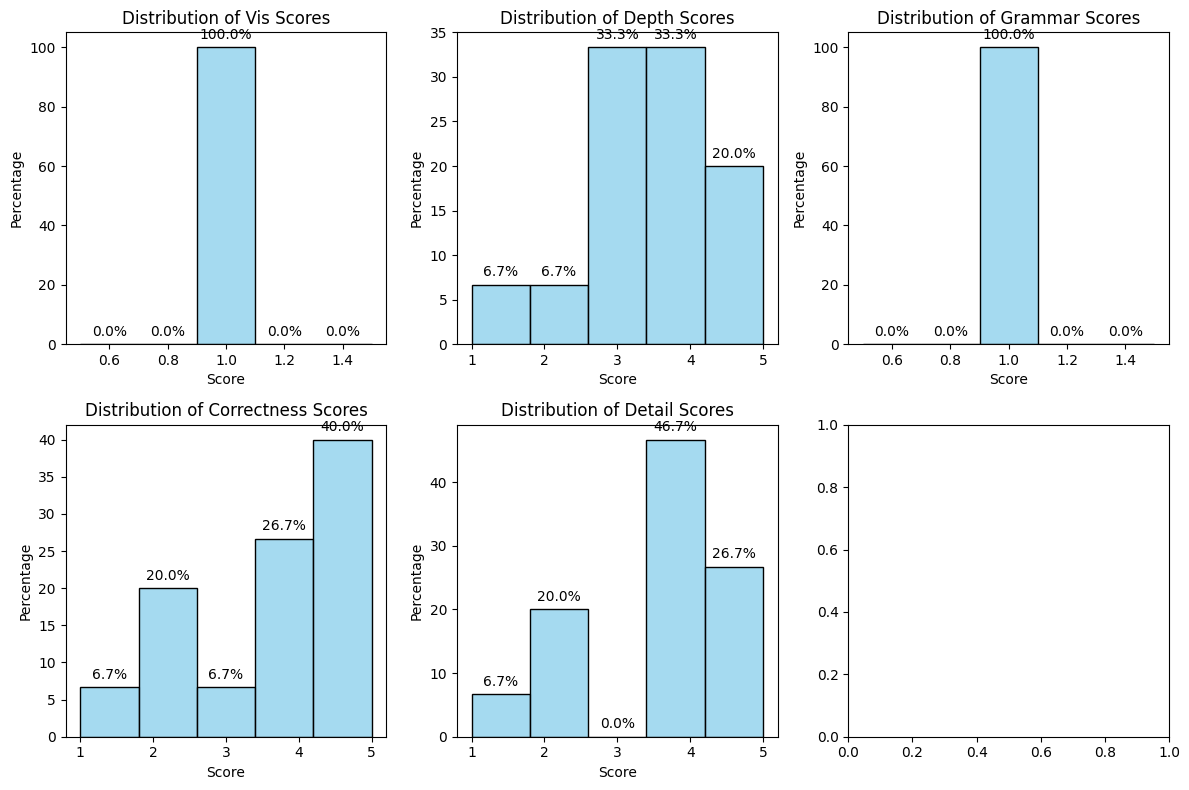

Average Vis Score: 1.00
Average Depth Score: 3.53
Average Grammar Score: 1.00
Average Correctness Score: 3.73
Average Detail Score: 3.67


In [13]:
task_config = 't1'  # change this to 't1', 't2', or 't3'
# Load the CSV file
visualize(task_config, t1_path)

### Task 2 Plot

Text Description 1: The woman lets go of the swinging rope and intentionally goes into the water.


Metrics:
 Correctness Score: 5
Correctness Reason: Because she did
Depth Score: 4
Depth Reason: Because it easily predictable
Grammar Score: 1
Grammar Reason: i could read it easily
Vis Score: 1
Vis Reason: not contradicting
Detail Score: 5
Detail Reason: yes


Text Description 2: The woman has fallen into the water and her friend jumps in after her to save her.


Metrics:
 Correctness Score: 2
Correctness Reason:  The description states that the woman has fallen into the water and her friend jumps in to save her. While this scenario is plausible, without the specifics of Part 1 and Part 3, we cannot determine if this is the most accurate representation of what happened in Part 2. 
Depth Score: 2
Depth Reason: The description provides a basic sequence of events but lacks deeper reasoning or context regarding why the woman fell or the urgency of the friend’s action. It presents a straightforward narrative without exploring motivations or surrounding circumstances, which could enhance understanding of the situation
Grammar Score: 1
Grammar Reason: The description is reasonably written with no major grammatical errors. It conveys the intended message clearly and effectively, making it easy to understand.
Vis Score: 1
Vis Reason: The scenario described follows logically from the implied events in Part 1 and Part 3, where a fall into the water could 

Metrics:
 Correctness Score: 4
Correctness Reason: It gives the correct and concise details
Depth Score: 4
Depth Reason: in my opinion
Grammar Score: 1
Grammar Reason: No . because it is not badly written
Vis Score: 1
Vis Reason: the video is of good quality
Detail Score: 4
Detail Reason: because it shows they are playing football and referee blew when the laDY WAS INJURED.


Text Description 4: Black player closest to ball falls on her face and gets embarrassed


Metrics:
 Correctness Score: 5
Correctness Reason: The description provided does not fully align with the context expected in Part 2 based on Part 1 and Part 3. While it describes an event involving a player falling and experiencing embarrassment, it lacks clarity on the circumstances leading to the fall and its significance within the broader narrative established by Parts 1 and 3.
Depth Score: 5
Depth Reason: he reasoning provided in the description is superficial. It mentions that the player fell and felt embarrassed but does not explore the emotions or implications of this action, such as how it affects the game or the reactions of other players or spectators. There is minimal reasoning offered to support this outcome.
Grammar Score: 1
Grammar Reason: Reasonably written
Explanation: The description is mostly clear and free of grammatical errors. It succinctly conveys the action that occurred, albeit with a lack of detail and context.
Vis Score: 1
Vis Reason: he description does not

Metrics:
 Correctness Score: 5
Correctness Reason: Yes, it's fully correct.
Depth Score: 3
Depth Reason: Yes, it is thoughtfully written and it supports the description.
Grammar Score: 1
Grammar Reason: The grammar is well written.th
Vis Score: 1
Vis Reason: The visuals reasonably follows what happened in the video.
Detail Score: 4
Detail Reason: There was not enough of detail but one can use his discretion to make the best guess.


Text Description 7: The man loses his balance and he falls, but the woman successfully lands on her feet.


Metrics:
 Correctness Score: 4
Correctness Reason: BECAUSE ITS THE LOGICAL THING TO HAPPEN
Depth Score: 4
Depth Reason: NOT MUCH EFFORT NEEDED TO COME UP WITH THIS SCENARIO
Grammar Score: 1
Grammar Reason: NO IT IS NOT BADLY WRITTEN 
Vis Score: 1
Vis Reason: YES IT IS THE MOST LOGICAL ANSWER
Detail Score: 4
Detail Reason: YES THERE IS ONLY THOSE OBJECTS THAT ARE DESCRIBED. 


Text Description 10: The man who threw the pitch stands up and turns around fully to look to where the ball was hit.  The batter continues to look on.


Metrics:
 Correctness Score: 5
Correctness Reason: This explanation fits perfectly with the sequence of events. It aligns with both part 1 and part 3.
Depth Score: 4
Depth Reason: Reasonably thoughtful, but the explanation could include more depth.
Grammar Score: 1
Grammar Reason: Grammatically Correct
Vis Score: 1
Vis Reason: Follows the video content. The description makes sense based on the scenario in parts 1 and 3.
Detail Score: 5
Detail Reason: The level of detail is sufficient to perfectly identify the people, objects and cause of actions. The person turning is identified as the one that threw the pitch.


Text Description 11: The man who threw the pitch does a double take between the batter and the space behind him.  The batter looks on while this happens.


Metrics:
 Correctness Score: 3
Correctness Reason: It is technically correct but doesn't explain why the batter sounds distressed.
Depth Score: 2
Depth Reason: It doesn't explain why the batter is swearing.
Grammar Score: 1
Grammar Reason: It is ckear and easy to understand with no obvious errors in grammar.
Vis Score: 1
Vis Reason: It follows.
Detail Score: 4
Detail Reason: It mentions both people.


Text Description 14: The skiier falls and appears injured or defeated as they lay in the snow.


Metrics:
 Correctness Score: 5
Correctness Reason: The answer is very plausibe.
Depth Score: 5
Depth Reason: By saying that the skier appears injured or defeated shows depth of reasoning
Grammar Score: 1
Grammar Reason: No errors
Vis Score: 1
Vis Reason: Very logical description that follows on well from the initial video
Detail Score: 5
Detail Reason: There is sufficient detail - I can't think of any additional pertinent detail that is missing


Text Description 16: Red Defender clears the ball away to safety


Metrics:
 Correctness Score: 3
Correctness Reason: I have no idea what happened to the ball. All I can see is that play was stopped when a player was knocked down.  I'm not even sure which player is "Red Defender".
Depth Score: 1
Depth Reason: The description is a possibility, but there is not enough detail for me to wholeheartedly support it. Too much happens in the hidden part of the video, and too little happens in the 3rd part.
Grammar Score: 0
Grammar Reason: The description is in readable English, but it speaks in soccer language, which I don't understand, so I don't really know what it means.
Vis Score: 0
Vis Reason: You don't give me an "I don't know" middle vote here. I chose "contradicts" because I cannot infer the hidden video based on this description.
Detail Score: 1
Detail Reason: Not at all. Who is "Red Defender" when all the red players are defenders? When there are no red players in the 3rd part of the video, how can I possibly know what happened between 1 and 3?


Tex

Metrics:
 Correctness Score: 5
Correctness Reason: Just my thought
Depth Score: 5
Depth Reason: I thought the narratives is evident in the video
Grammar Score: 1
Grammar Reason: No error
Vis Score: 1
Vis Reason: It is possible for it to happen
Detail Score: 3
Detail Reason: Part 2 wasn't given


Text Description 19: The skiier falls and begins to laugh as he lays in the snow.


Metrics:
 Correctness Score: 1
Correctness Reason: The skier does not look as though he was in any way amused
Depth Score: 2
Depth Reason: It's just about possible, but I acn't see any evidence for the claim
Grammar Score: 0
Grammar Reason: It is written in the present tense, which is inapprpriate for the given prompt
Vis Score: 0
Vis Reason: The fact that the skier is prone, on the ground, rather contradicts the claim
Detail Score: 2
Detail Reason: It contains some detail, but it's a very brief description 


Text Description 21: The man loses his balance and he and the woman both topple over and fall.


Metrics:
 Correctness Score: 4
Correctness Reason: The 3rd video shows the man on the floor so he must have fallen in the 2nd video.
Depth Score: 4
Depth Reason: It correctly states how the man could have fallen int he 3rd video.
Grammar Score: 1
Grammar Reason: It's written reasonably well.
Vis Score: 1
Vis Reason: It follows the videos correctly.
Detail Score: 4
Detail Reason: It states the people in the video but not the objects.


Text Description 23: The woman tries to juggle and accidentally hits the man in the head with one of the items in her hands.


Metrics:
 Correctness Score: 3
Correctness Reason: yes. it give full information
Depth Score: 3
Depth Reason: Based on my knowledge
Grammar Score: 1
Grammar Reason: No . because it is not badly written
Vis Score: 1
Vis Reason: the video is of good quality
Detail Score: 3
Detail Reason: because it shows they are playing football and referee blew when the lady was injured.


Text Description 24: The skiier does not make the jump and lays in the snow.


Metrics:
 Correctness Score: 2
Correctness Reason: It is one possibility among many.
Depth Score: 3
Depth Reason: There was thought given to the missing section, it could have benefited from more depth of description or writing.
Grammar Score: 1
Grammar Reason: It uses correct spelling, punctuation, and grammar.
Vis Score: 1
Vis Reason: Nothing condradicts.
Detail Score: 3
Detail Reason: Its of average detail, just enough to make the reader understand without any extra.




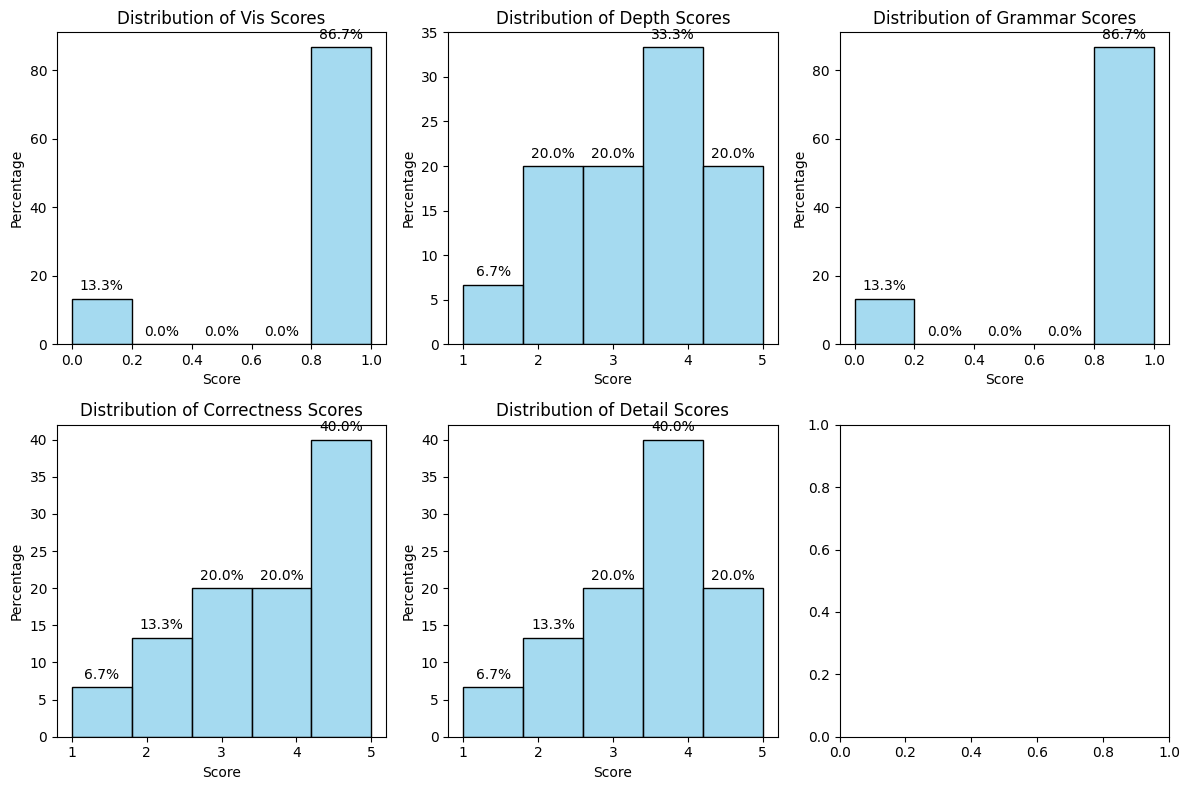

Average Vis Score: 0.87
Average Depth Score: 3.40
Average Grammar Score: 0.87
Average Correctness Score: 3.73
Average Detail Score: 3.53


In [14]:
task_config = 't2'  # change this to 't1', 't2', or 't3'
# Load the CSV file
visualize(task_config, t2_path)

### Task 3 Plot

Text Description 1: Black team players collides with red team players, takes a blow to the face, falls to ground


Metrics:
 Correctness Score: 1
Correctness Reason: That is not what the second video shows. The Black team player was next to the red team player. The player on the red team then kicked the ball, accidently hitting the player from the black team in the face causing her to fall to the ground.
Depth Score: 1
Depth Reason: It is completely wrong. The scenario is incorrect and does not accurately answer the question as to what happened in the video. It also does not give details as to what happened to cause the player from the black team to fall.
Grammar Score: 1
Grammar Reason: Yes it is badly written, there are a few spots where the grammar is incorrect. 
Vis Score: 1
Vis Reason: No. It is completely inaccurate as to what happened in the video. It does not really describe who was involved in the fall and why they fell.
Detail Score: 1
Detail Reason: There is almost no detail in the answer. It is very short and once again incorrect.


Text Description 2: The woman loses her grip on the sw

Metrics:
 Correctness Score: 5
Correctness Reason: It happened as stated
Depth Score: 5
Depth Reason: Yes, because you see her coming back to the edge
Grammar Score: 1
Grammar Reason: I do not believe there were grammatical errors
Vis Score: 1
Vis Reason: The description reasonably follows what happened in the video
Detail Score: 5
Detail Reason: You can clearly see what the person is doing 


Text Description 4: The man tries to shift his weight on on the board but loses his balance. He falls to the ground as the woman successfully lands on her feet, demonstrating incredible balance. She looks back at the man to make sure he is okay and begins to approach him.


Metrics:
 Correctness Score: 4
Correctness Reason: Very accurate but not a very good description of the board that they are balancing on, and does not mention that the woman is balancing on his shoulders.
Depth Score: 4
Depth Reason: Could be more descriptive of the act taking place.
Grammar Score: 0
Grammar Reason: Contains two instances of on in the first sentence.
Vis Score: 1
Vis Reason: Follows the video content.
Detail Score: 3
Detail Reason: It describes balancing on a board but does not describe it in sufficient detail to achieve a higher score.


Text Description 5: The skiier smacks his back off the jumping platform and completely loses consciousness. He lays still, apparently injured, in the snow below the jump.


Metrics:
 Correctness Score: 4
Correctness Reason: I am not sure if the skiier loses consciousness.
Depth Score: 4
Depth Reason: It was well described.
Grammar Score: 1
Grammar Reason: The grammer seemed ok.
Vis Score: 1
Vis Reason: It follows reasonably.
Detail Score: 4
Detail Reason: The detail seemed sufficient.


Text Description 9: The guy jumping lands with one leg into the trashcan but his momentum causes the trashcan to fall over.


Metrics:
 Correctness Score: 4
Correctness Reason: It describes the event very well.
Depth Score: 4
Depth Reason: Yes, it is very thoughtful.
Grammar Score: 1
Grammar Reason: The grammar is good and easy to understand.
Vis Score: 1
Vis Reason: The description reasonable follows what was displayed in the video.
Detail Score: 4
Detail Reason: Yes, the video has sufficient details to easily identify the people and object



Text Description 11: The man in the blue tank top performs a gymnastic feat and the rope in his left hand snaps. He continues to perform a half gym routine while a woman in the background laughs before letting go of the rope.


Metrics:
 Correctness Score: 5
Correctness Reason: That was what I saw
Depth Score: 5
Depth Reason: It was exactly what happened
Grammar Score: 1
Grammar Reason: The spellings are correct
Vis Score: 1
Vis Reason: It follows everything written down
Detail Score: 5
Detail Reason: Everything written down in green was what was portryed


Text Description 12: A fully clothed adult is going down a child's water slide. Due to his size and speed he is going so fast that he ends up flying out the pool and onto the ground in front of the person recording him.


Metrics:
 Correctness Score: 4
Correctness Reason: The explanation fits the key actions of the sequence
Depth Score: 4
Depth Reason: It explains how fast the person is moving and how the person ended up on the the ground
Grammar Score: 1
Grammar Reason: The grammar used reasonable
Vis Score: 1
Vis Reason: It follows the video content
Detail Score: 4
Detail Reason: It tells you how grown the person is,their clothings and on a children water slide


Text Description 14: Cape of performers gets stuck on stage and stays on, but pulls them back, causing a distraction


Metrics:
 Correctness Score: 5
Correctness Reason: It is accurate.
Depth Score: 4
Depth Reason: It explains the incident correctly.
Grammar Score: 1
Grammar Reason: There is some minor phrasing but it is understandable.
Vis Score: 1
Vis Reason: Yes, it reasonably follows.
Detail Score: 4
Detail Reason: It identifies the person of interest.


Text Description 16: The woman gets stuck on the post when attempting to hop over it, causing her to fall down.


Metrics:
 Correctness Score: 4
Correctness Reason: It correctly explains what happens but leaves out the detail that someone came to help her get up.
Depth Score: 4
Depth Reason: It is thoughtful but lacks clear mention of someone coming to help her.
Grammar Score: 1
Grammar Reason: The grammar is very good
Vis Score: 1
Vis Reason: There is no contradiction in the description
Detail Score: 3
Detail Reason: The attention to detail is slightly good but lacks the fine detail of someone coming to help her stand and makes no mention of what she or the person were wearing


Text Description 17: Person on left blows glasses with straw, causing them to fall down and fire starts on table


Metrics:
 Correctness Score: 2
Correctness Reason: No full context
Depth Score: 2
Depth Reason: Not very descriptive.
Grammar Score: 1
Grammar Reason: Not perfect, but understandable.
Vis Score: 1
Vis Reason: Is accurate.
Detail Score: 2
Detail Reason: Low details


Text Description 18: The hot dog falls to the ground. The young man sitting next to the hot dog eater picks it up, hands it to the man, who places it back into the food container.


Metrics:
 Correctness Score: 3
Correctness Reason: It has the true facts 
Depth Score: 2
Depth Reason: Just a guy eating gross food.
Grammar Score: 0
Grammar Reason: Na
Vis Score: 0
Vis Reason: Na
Detail Score: 2
Detail Reason: Na


Text Description 20: Person on top falls backwards, causing the person on the bottom to start laughing and fall forward to the ground


Metrics:
 Correctness Score: 5
Correctness Reason: The description aligns with what I saw happen in the video
Depth Score: 4
Depth Reason: The description was not written as a full sentence.
Grammar Score: 1
Grammar Reason: Though the sentence was not complete, the amount of detail provided is enough to tell what happened in the video.
Vis Score: 1
Vis Reason: There is an almost perfect alignment between the video and the description.
Detail Score: 4
Detail Reason: The part that a woman climbed to the neck of another woman sitting down was omitted from the description.


Text Description 21: The guy continues to swing his sword in the air until he hits the chandelier above, knocking out the lights, which causes him to stop playing with this sword.


Metrics:
 Correctness Score: 5
Correctness Reason: The explanation is a perfect description of the video
Depth Score: 3
Depth Reason: This is a description and doesn't really involve much depth in thought, though the description is succinct
Grammar Score: 1
Grammar Reason: The grammar is good
Vis Score: 1
Vis Reason: It is a perfect description of the video
Detail Score: 5
Detail Reason: The description is detailed


Text Description 22: Groom drops the bride and she pulls him down to the floor on her way down


Metrics:
 Correctness Score: 5
Correctness Reason: I rated it a 5 because I personally think that the description is fully correct.
Depth Score: 5
Depth Reason: I rated it a 5 because I thought that there was sufficient reasoning to support the description. The video clearly shows the groom dropping the bride and they both fall because the bride pulls him down with her.
Grammar Score: 1
Grammar Reason: I did not see any grammatical errors in the description.
Vis Score: 1
Vis Reason: The description reasonably follows what is happening in the video.
Detail Score: 5
Detail Reason: I rated it a 5 because I believe that the description has a sufficient level of detail to easily identify and differentiate between the people (groom and bride) and other objects.


Text Description 24: The man accidently flies his drone into the poster on the wall.  The drone automatically malfunctions and falls onto the floor.  The man with the remote expresses shock.


Metrics:
 Correctness Score: 3
Correctness Reason: While the broad outline of the event is correct, the drone does not fall because it 'automatically malfunctions,' but rather because its rotors hit the poster, the wall, the table, and then the floor.
Depth Score: 3
Depth Reason: The description lacks a clear account of the chain of events that caused the drone to fall.
Grammar Score: 1
Grammar Reason: The description is gramatically correct.
Vis Score: 1
Vis Reason: The description follows what takes place in the videos.
Detail Score: 4
Detail Reason: The description acks a specific description of why the drone falls. It is also not clear from the description where the event is taking place, which is a significant part of the context of the video.




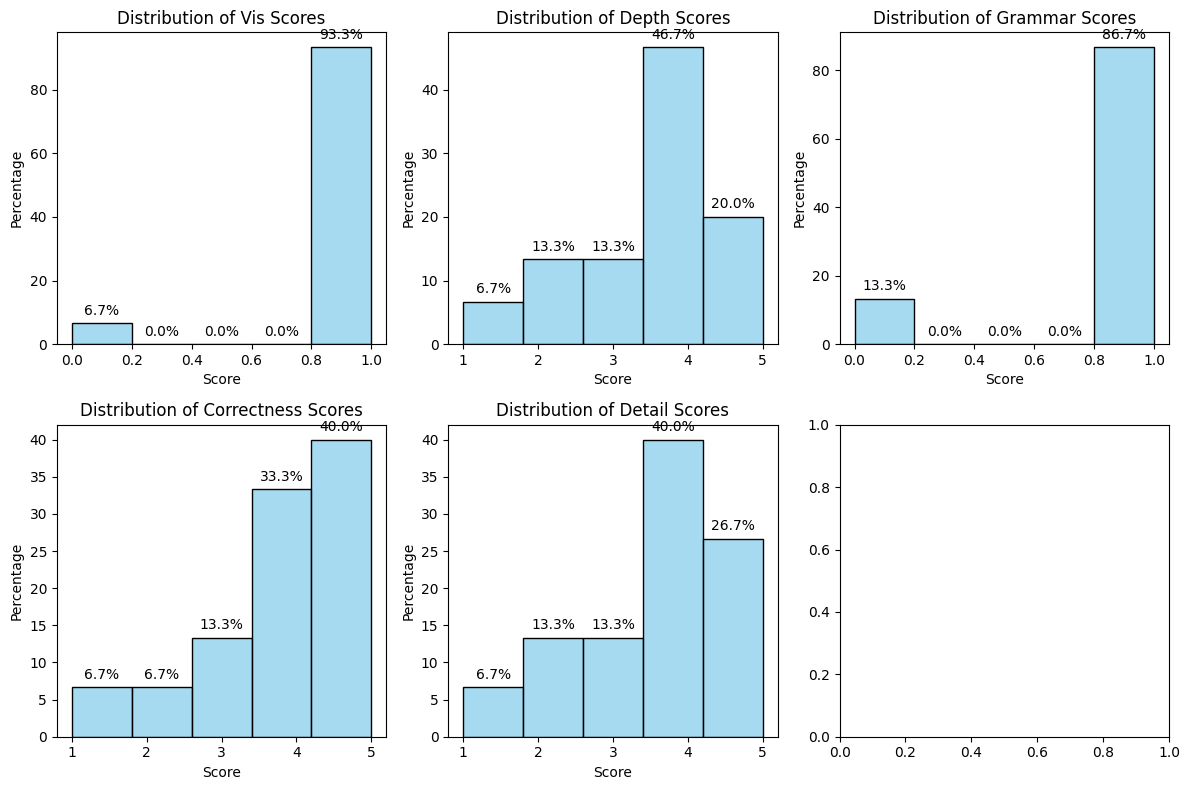

Average Vis Score: 0.93
Average Depth Score: 3.60
Average Grammar Score: 0.87
Average Correctness Score: 3.93
Average Detail Score: 3.67


In [15]:
task_config = 't3'  # change this to 't1', 't2', or 't3'
# Load the CSV file
visualize(task_config, t3_path)